In [1]:
%load_ext autoreload
%autoreload 2

### Imports

In [2]:
import json
from IPython.display import Image
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from pathlib import Path
import seaborn as sns
import time
from tqdm import tqdm
from typing import List
#from typing import Union

from pykeen.evaluation import RankBasedEvaluator
from pykeen.triples import TriplesFactory
import toml
import torch

/home/jovyan/.conda/envs/bioblp-env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
from nb_utils.eval_utils import TEST, VALID, TRAIN, DUMMY
from nb_utils.eval_utils import EVAL_METRICS_CATALOG, EVAL_METRICS_SHORTLIST
from nb_utils.eval_utils import COL_SOURCE, COL_TARGET, COL_EDGE, COL_NODE, DEGREE, IN_DEGREE, OUT_DEGREE
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
from nb_utils.eval_utils import setup_wandb_result_tracker, run_experiment_and_log_wandb
from nb_utils.eval_utils import compute_node_degrees_in_out
from nb_utils.eval_utils import load_kge_model
from nb_utils.eval_utils import create_entity_attr_aware_test_sets
from nb_utils.eval_utils import make_results_dict_all_rel


from nb_utils.config import ARTIFACT_REGISTRY_TOML_PATH, EntityType
from nb_utils.config import load_toml, ModelRegistryConfig, EvaluationConfig
from nb_utils.config import GraphRegistryConfig, EntityType
from nb_utils.config import PROTEIN, DRUG, DISEASE
from nb_utils.eval_utils import ENT_ASSOC_REL_NAMES, EVAL_METRIC_REALISTIC, EVAL_NODE_HEAD, EVAL_NODE_TAIL
from nb_utils.eval_utils import PROT_ASSOC_REL_NAMES, test_rel_list_validity, ENT_ASSOC_REL_NAMES
from nb_utils.eval_utils import TEST, TRAIN, VALID, DUMMY
from nb_utils.eval_utils import TEST_RESTRICTED_PROTEIN, TEST_RESTRICTED_DISEASE, TEST_RESTRICTED_DRUG
from nb_utils.eval_utils import ENT_SPECIFIC_TEST_SET_STUBS

### load data

1. add the paths to the following models and biokg files in ./nb_utils/artifact_registry.toml


In [5]:
ROTATE = "rotate-otxtubeb"
BIOBLP_D = "bioblpd-38uz9fjs-16-03-2023" 
BIOBLP_P = "rotate-bioblp-p-4o6x9h96"
BIOBLP_M = "rotate-bioblp-m-1r75g9na"
BIOBLP_D_old = "bioblpd-38uz9fjs"  # older pykeen and BioBLP version
#BIOBLP_P = "bioblpp-cttc3ucm" # this was not pretrained
#BIOBLP_M = "bioblpm-5rxz3k57" # this was not pretrained


In [6]:
toml_path = ARTIFACT_REGISTRY_TOML_PATH
model_reg_cfg = ModelRegistryConfig.from_toml(toml_path)
model_registry_paths = model_reg_cfg.registered_model_paths
model_training_paths = model_reg_cfg.registered_model_training_triples_paths

In [7]:
graph_cfg = GraphRegistryConfig.from_toml(ARTIFACT_REGISTRY_TOML_PATH)


### load triples data

In [9]:
# load training splits
MODEL_ID = ROTATE  # BIOBLP_D
train = TriplesFactory.from_path_binary(model_training_paths[MODEL_ID])


valid, test = [TriplesFactory.from_path(f,
                                        entity_to_id=train.entity_to_id,
                                        relation_to_id=train.relation_to_id)
               for f in (map(graph_cfg.biokgb_data_splits.get, [VALID, TEST]))]


In [10]:
triples_dict = {
    TEST: test,
    VALID: valid,
    TRAIN: train,    
}

#### Split test triples conditional on whether they contain entities whose properties were encoded in BIOBLP-X vs not

In [11]:
LIST_ENTITY_TYPES_W_ATTRIBUTE = [DRUG, PROTEIN, DISEASE]

for ent_type in LIST_ENTITY_TYPES_W_ATTRIBUTE:
    print(f"Creating test sets with triples restricted to containing {ent_type}")
    test_triples_incl_ent_prop, test_triples_excl_ent_prop = create_entity_attr_aware_test_sets(entity_type_w_attribute=ent_type,
                                                                                            graph_cfg=graph_cfg,
                                                                                            train=train,
                                                                                            test=test) 
    triples_dict.update({ENT_SPECIFIC_TEST_SET_STUBS[ent_type]: test_triples_incl_ent_prop})
    
    
triples_dict.keys()

Creating test sets with triples restricted to containing drug


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


# drug entities in larger biokg (pre-benchmark removal): 13580
# drug entities for which we have attributes: 10815
Creating test sets with triples restricted to containing protein
# protein entities in larger biokg (pre-benchmark removal): 122902
# protein entities for which we have attributes: 121988


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


Creating test sets with triples restricted to containing disease
# disease entities in larger biokg (pre-benchmark removal): 11347
# disease entities for which we have attributes: 11347


Reconstructing all label-based triples. This is expensive and rarely needed.


dict_keys(['test', 'valid', 'train', 'TEST_RESTRICTED_DRUG', 'TEST_RESTRICTED_PROTEIN', 'TEST_RESTRICTED_DISEASE'])

In [12]:
# create set of triples
print(f"# triples originally in test: {test.num_triples}, valid: {valid.num_triples}")
for ent_type in LIST_ENTITY_TYPES_W_ATTRIBUTE:
    print(f"# test triples with {ent_type} nodes: {triples_dict[ENT_SPECIFIC_TEST_SET_STUBS[ent_type]].num_triples}")


# triples originally in test: 185227, valid: 185226
# test triples with drug nodes: 123636
# test triples with protein nodes: 54064
# test triples with disease nodes: 17063


## Plots

#### exploratory peek into transformed data and distributions

In [17]:
from nb_utils.eval_utils import NodeDegreeEvalAnalyser
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN
test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde_ = NodeDegreeEvalAnalyser(train_triples=train,
                           rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)

test_triples_ent_w_attr_df = nde_.prep_test_data(test_triples_incl_ent_prop)

test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde_._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


In [18]:
# we see the count of triples where the {ENTITY_TYPE_W_ATTR_ENCODE} occurs as the head/src vs tail/tgt
triples_by_node_endpoint = {node_endpoint: len(test_triples_by_node_endpoint_to_predict[node_endpoint]) for node_endpoint in [COL_SOURCE, COL_TARGET]}
triples_by_node_endpoint

{'src': 52678, 'tgt': 1386}

In [19]:
print(f"Counts of triples with {ENTITY_TYPE_W_ATTR_ENCODE} in src/tgt position {triples_by_node_endpoint}")
print(f"i.e.,{round((triples_by_node_endpoint[COL_SOURCE])/(triples_by_node_endpoint[COL_TARGET]+triples_by_node_endpoint[COL_SOURCE])*100, 2)}% test triples with {ENTITY_TYPE_W_ATTR_ENCODE} occuring in source position than in tail position")

Counts of triples with protein in src/tgt position {'src': 52678, 'tgt': 1386}
i.e.,97.44% test triples with protein occuring in source position than in tail position


In [20]:
NODE_ENDPOINT_TO_PREDICT = COL_SOURCE
print(f"Restricting analysis to relations where we predict '{ENTITY_TYPE_W_ATTR_ENCODE}' as '{NODE_ENDPOINT_TO_PREDICT}'")

Restricting analysis to relations where we predict 'protein' as 'src'


In [21]:
rels_for_ent_w_attr_as_src = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_SOURCE]
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE].isin(rels_for_ent_w_attr_as_src)][f'{COL_SOURCE}_training_degree'].describe()

count    52678.000000
mean        53.009795
std         67.602469
min          1.000000
25%         11.000000
50%         29.000000
75%         65.000000
max        480.000000
Name: src_training_degree, dtype: float64

In [22]:
rels_w_prot_as_tgt = ENT_ASSOC_REL_NAMES[ENTITY_TYPE_W_ATTR_ENCODE][COL_TARGET]
test_triples_ent_w_attr_df[test_triples_ent_w_attr_df[COL_EDGE].isin(rels_w_prot_as_tgt)][f'{COL_TARGET}_training_degree'].describe()

count    1386.000000
mean       75.972583
std        82.988725
min         1.000000
25%        24.000000
50%        44.000000
75%        97.000000
max       409.000000
Name: tgt_training_degree, dtype: float64

In [23]:
from nb_utils.eval_utils import get_unique_endpoint_entities_in_testset_of_given_degree

DEGREE = 1
unique_ent_w_attr_as_src_in_test = get_unique_endpoint_entities_in_testset_of_given_degree(test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT], 
                                                                                           degree=DEGREE, node_endpoint_type=COL_SOURCE)
print(f"# unique entities of type '{ENTITY_TYPE_W_ATTR_ENCODE}' of training degree {DEGREE} in associated triples where it occurs in position {NODE_ENDPOINT_TO_PREDICT}: {len(unique_ent_w_attr_as_src_in_test)}")



# unique entities of type 'protein' of training degree 1 in associated triples where it occurs in position src: 803


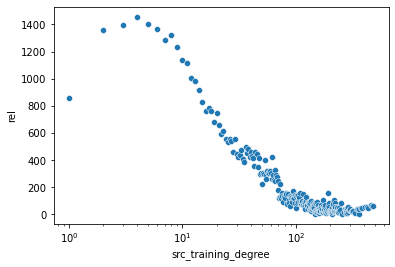

In [24]:
import seaborn as sns
test_triples_prot_as_src = test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT]
prot_degrees = test_triples_prot_as_src.groupby(['src_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=prot_degrees, x='src_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

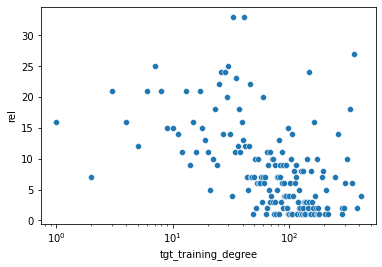

In [25]:
import seaborn as sns
test_triples_prot_as_tgt = test_triples_by_node_endpoint_to_predict[COL_TARGET]
prot_degrees = test_triples_prot_as_tgt.groupby(['tgt_training_degree'])[COL_EDGE].agg('count').reset_index()
sns.scatterplot(data=prot_degrees, x='tgt_training_degree', y='rel')
plt.xscale('log')
#plt.yscale('log')

<AxesSubplot:ylabel='tgt_training_degree'>

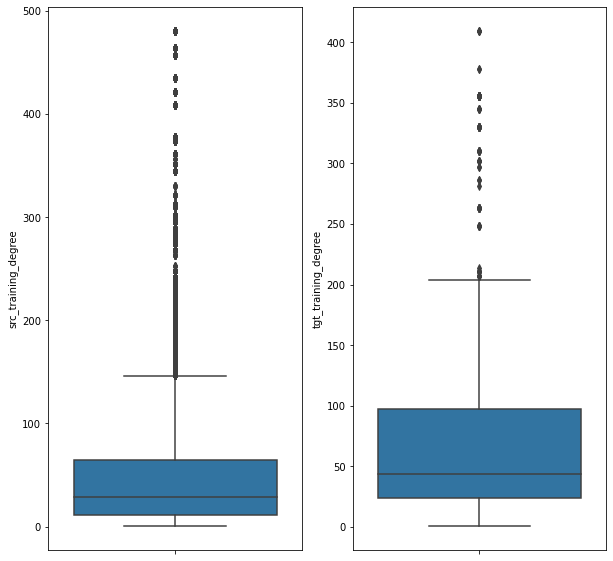

In [26]:
plot, ax = plt.subplots(1, 2, figsize=(10,10))
sns.boxplot(ax=ax[0], y=test_triples_prot_as_src['src_training_degree'])
sns.boxplot(ax=ax[1], y=test_triples_prot_as_tgt['tgt_training_degree'])

In [28]:
from pykeen.triples.triples_factory import TriplesFactory
train_triples=triples_dict.get(TRAIN)
valid_triples=triples_dict[VALID]

## Plot - Plotting the difference in LP scores by RotatE and BioBLP-X

Prerequisites:
- Get the json files for evaluation metrics by node degree from [Google drive](https://drive.google.com/file/d/1m9G9R_oYwpazNcUdAz-TESJsrIlCCQHb/view?usp=share_link) 
- unpack and place the above archive in a directory `BioBLP/notebooks/metrics`

### define plotting logic

In [13]:
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_multi_models
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.eval_utils import EVAL_METRICS_CATALOG, get_unique_endpoint_entities_in_testset_of_given_degree
from nb_utils.eval_utils import INVERSE_HARMONIC_MEAN_RANK
from nb_utils.eval_utils import HITS_AT_1, HITS_AT_3, HITS_AT_10
from nb_utils.plot_utils import merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff
import matplotlib.ticker as ticker
import seaborn as sns

In [40]:
from nb_utils.eval_utils import NodeDegreeEvalAnalyser


In [17]:
NODE_DEGREE_EVAL_RESULTS_DIR = Path("/home/jovyan/BioBLP/notebooks/metrics/node_degree_eval_lp/combined_spotlight_ent_as_src_and_tgt")
ent_type_specific_models = {
    DISEASE: [ROTATE, BIOBLP_D],
    PROTEIN: [ROTATE, BIOBLP_P],
    DRUG: [ROTATE, BIOBLP_M]
}
eval_out_dir = NODE_DEGREE_EVAL_RESULTS_DIR
results_dicts = {}
for ent_type, model_list in ent_type_specific_models.items():
    print(ent_type, model_list)
    results_dicts.update({ent_type: {}})
    for model_name in model_list:
        file_name = f"node-degree-eval-{model_name}-spotlight-{ent_type}-as-src-and-tgt.json"
        with open(eval_out_dir.joinpath(file_name), 'r') as f:
            result = json.load(f)       
            results_dicts[ent_type].update({model_name: result})

disease ['rotate-otxtubeb', 'bioblpd-38uz9fjs-16-03-2023']
protein ['rotate-otxtubeb', 'rotate-bioblp-p-4o6x9h96']
drug ['rotate-otxtubeb', 'rotate-bioblp-m-1r75g9na']


Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


,degree,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,count,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,67.0,0.174061,0.395904,0.511945,0.617747,0.323485,293,0.075085,0.139932,0.225256,0.283276,0.141346,43,0.098976,0.255973,0.286689,0.334471,0.182140
1,61.0,0.193916,0.342205,0.425856,0.581749,0.305905,263,0.038023,0.072243,0.133080,0.228137,0.085021,46,0.155894,0.269962,0.292776,0.353612,0.220883
2,7.0,0.090008,0.172387,0.217391,0.282990,0.152639,1311,0.028223,0.031274,0.032799,0.034325,0.030723,905,0.061785,0.141114,0.184592,0.248665,0.121916


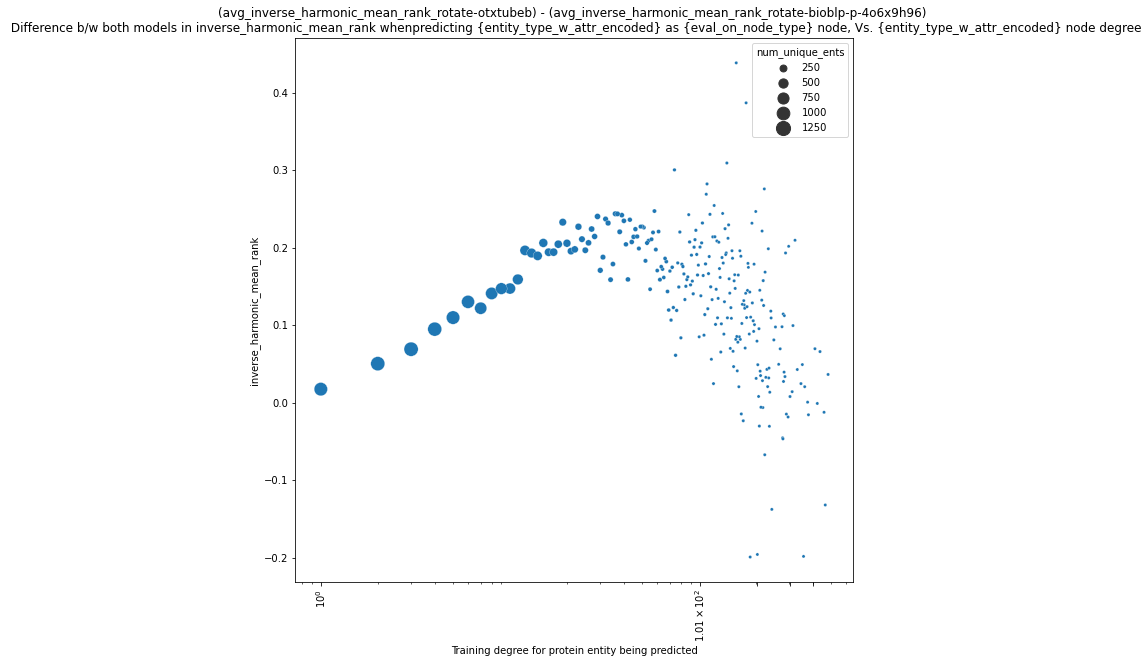

In [18]:
ENTITY_TYPE_W_ATTR_ENCODE = PROTEIN
BIOBLP_MODEL_ID = BIOBLP_P
ROTATE_MODEL_ID = ROTATE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

merged_bioblpp_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                                                       bioblp_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][BIOBLP_MODEL_ID],
                                                                                       rotate_model_id=ROTATE_MODEL_ID,
                                                                                       rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                                                       node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                                                       eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                                                       test_triples=test_triples_ent_w_attr_df,
                                                                                       entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                                                       metric_name=INVERSE_HARMONIC_MEAN_RANK) 
merged_bioblpp_rotate_df[:3]

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,429.0,80,0.062500,0.150000,0.187500,0.375000,0.147620,0.05,0.06250,0.062500,0.087500,0.071328,4,0.012500,0.087500,0.125000,0.287500,0.076292
1,269.0,27,0.000000,0.074074,0.148148,0.296296,0.084560,0.00,0.00000,0.037037,0.037037,0.027240,7,0.000000,0.074074,0.111111,0.259259,0.057320
2,733.0,92,0.097826,0.271739,0.347826,0.500000,0.219906,0.00,0.01087,0.021739,0.054348,0.018369,1,0.097826,0.260870,0.326087,0.445652,0.201537


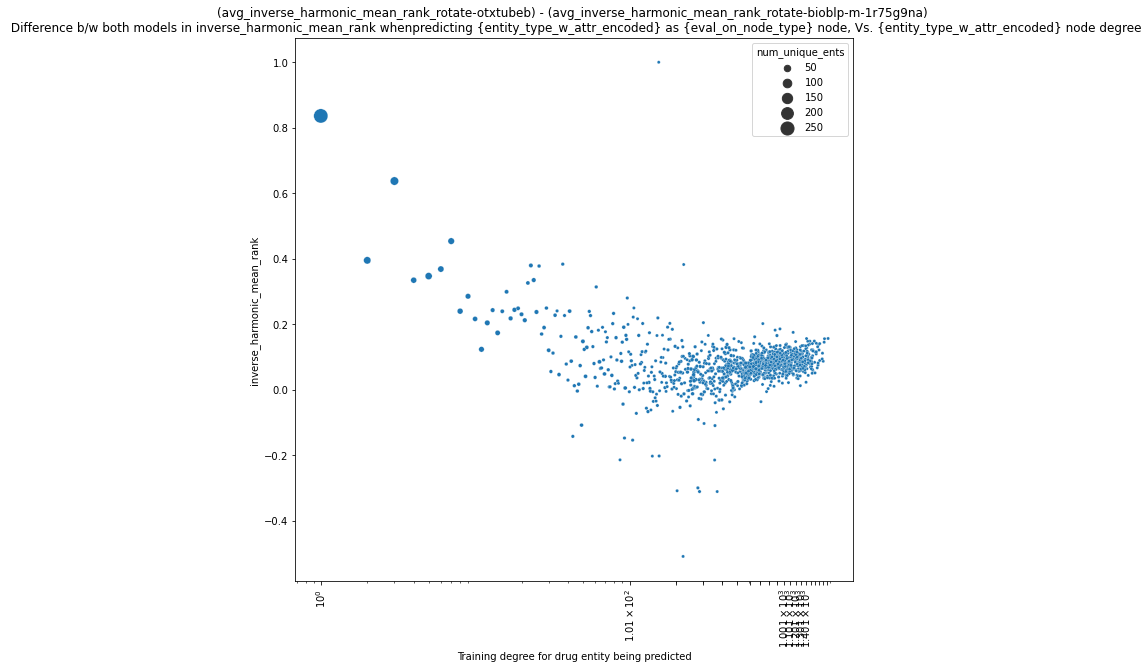

In [19]:
ENTITY_TYPE_W_ATTR_ENCODE = DRUG
BIOBLP_MODEL_ID = BIOBLP_M
ROTATE_MODEL_ID = ROTATE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

merged_bioblpm_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                                                       bioblp_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][BIOBLP_MODEL_ID],
                                                                                       rotate_model_id=ROTATE_MODEL_ID,
                                                                                       rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                                                       node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                                                       eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                                                       test_triples=test_triples_ent_w_attr_df,
                                                                                       entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                                                       metric_name=INVERSE_HARMONIC_MEAN_RANK) 
merged_bioblpm_rotate_df[:3]

**DO NOT USE THE BIOBLP_D, USE THE BIOBLP_D_OLD VARIANT DEMONSTRATED AFTER THE IMMEDIATE CELL**

Reconstructing all label-based triples. This is expensive and rarely needed.
Reconstructing all label-based triples. This is expensive and rarely needed.


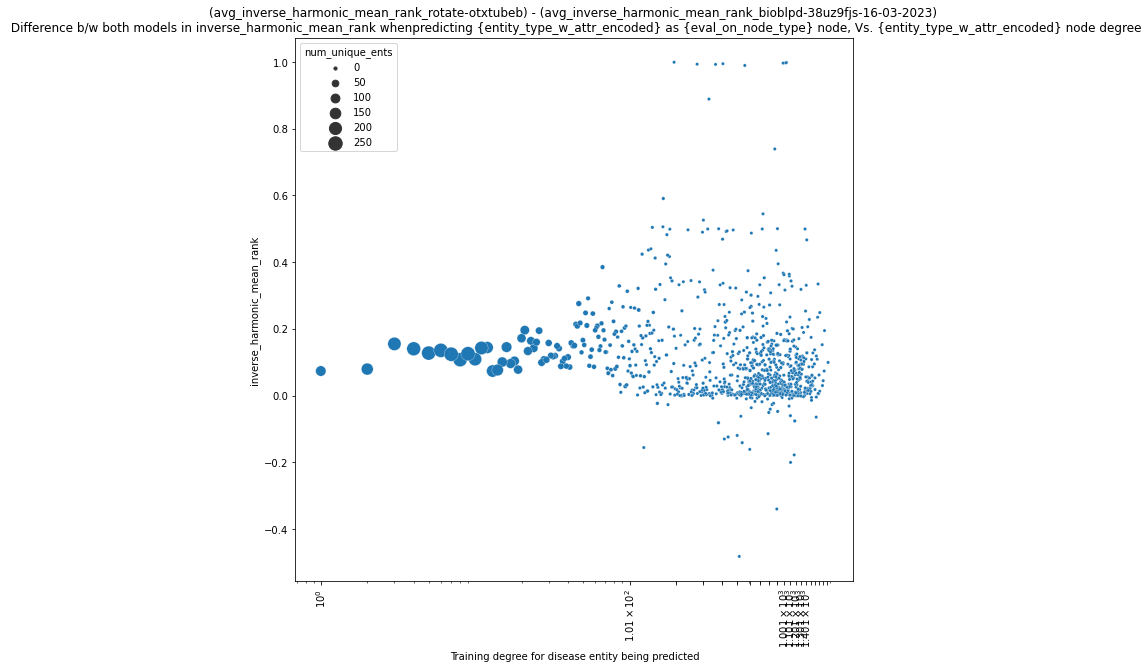

,degree,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,count,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,inverse_harmonic_mean_rank_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,148.0,0.275862,0.379310,0.413793,0.517241,0.342010,29,0.000000,0.034483,0.034483,0.103448,0.023348,4,0.275862,0.344828,0.379310,0.413793,0.318662
1,4.0,0.161905,0.273016,0.298413,0.358730,0.235106,315,0.069841,0.098413,0.117460,0.139683,0.094960,264,0.092063,0.174603,0.180952,0.219048,0.140145
2,2.0,0.118943,0.171806,0.207048,0.268722,0.169113,227,0.070485,0.096916,0.105727,0.118943,0.089802,192,0.048458,0.074890,0.101322,0.149780,0.079311


In [41]:
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D
ROTATE_MODEL_ID = ROTATE

test_triples_incl_ent_prop = triples_dict.get(ENT_SPECIFIC_TEST_SET_STUBS.get(ENTITY_TYPE_W_ATTR_ENCODE))

nde = NodeDegreeEvalAnalyser(train_triples=train,
                             rels_assoc_by_node_endpoint_type_dict=ENT_ASSOC_REL_NAMES)
test_triples_ent_w_attr_df = nde.prep_test_data(test_triples_incl_ent_prop)

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                                                       bioblp_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][BIOBLP_MODEL_ID],
                                                                                       rotate_model_id=ROTATE_MODEL_ID,
                                                                                       rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                                                       node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                                                       eval_on_node_endpoint='tail',
                                                                                       test_triples=test_triples_ent_w_attr_df,
                                                                                       #test_triples=test_triples_by_node_endpoint_to_predict[NODE_ENDPOINT_TO_PREDICT],
                                                                                       entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                                                       metric_name=INVERSE_HARMONIC_MEAN_RANK) 
merged_bioblpd_rotate_df[:3]

### loading older BioBLP-D (pretrained) model

In [35]:
eval_out_file_bioblpd_old = './metrics/bioblpd-38uz9fjs/node-degree-eval.json'
eval_out_file_bioblpd_old = './metrics/node_degree_eval_lp/spotlight_ent_as_src/node-degree-eval-bioblpd-38uz9fjs-spotlight-disease-as-src.json'
with open(eval_out_file_bioblpd_old, 'r') as f:
    results_by_node_degree_dicts_bioblpd_old = json.load(f)
    
eval_out_file_rotate_disease_as_src = './metrics/node_degree_eval_lp/spotlight_ent_as_src/node-degree-eval-rotate-otxtubeb-spotlight-disease-as-src.json'
with open(eval_out_file_rotate_disease_as_src, 'r') as f:
    results_by_node_degree_dicts_rotate_disease_src = json.load(f)

,degree,count,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,arithmetic_mean_rank,adjusted_arithmetic_mean_rank,inverse_harmonic_mean_rank_bioblp,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,148.0,26,0.115385,0.269231,0.346154,0.461538,0.227222,546.261902,0.010306,0.076215,0.047619,0.047619,0.071429,0.142857,4,0.067766,0.221612,0.274725,0.318681,0.151008
1,4.0,291,0.020619,0.027491,0.037801,0.037801,0.028698,601.184204,0.011342,0.089921,0.052632,0.098684,0.105263,0.164474,254,-0.032013,-0.071193,-0.067462,-0.126673,-0.061223
2,2.0,207,0.000000,0.000000,0.000000,0.004831,0.002660,751.289856,0.014175,0.040792,0.007246,0.050725,0.072464,0.108696,189,-0.007246,-0.050725,-0.072464,-0.103865,-0.038132


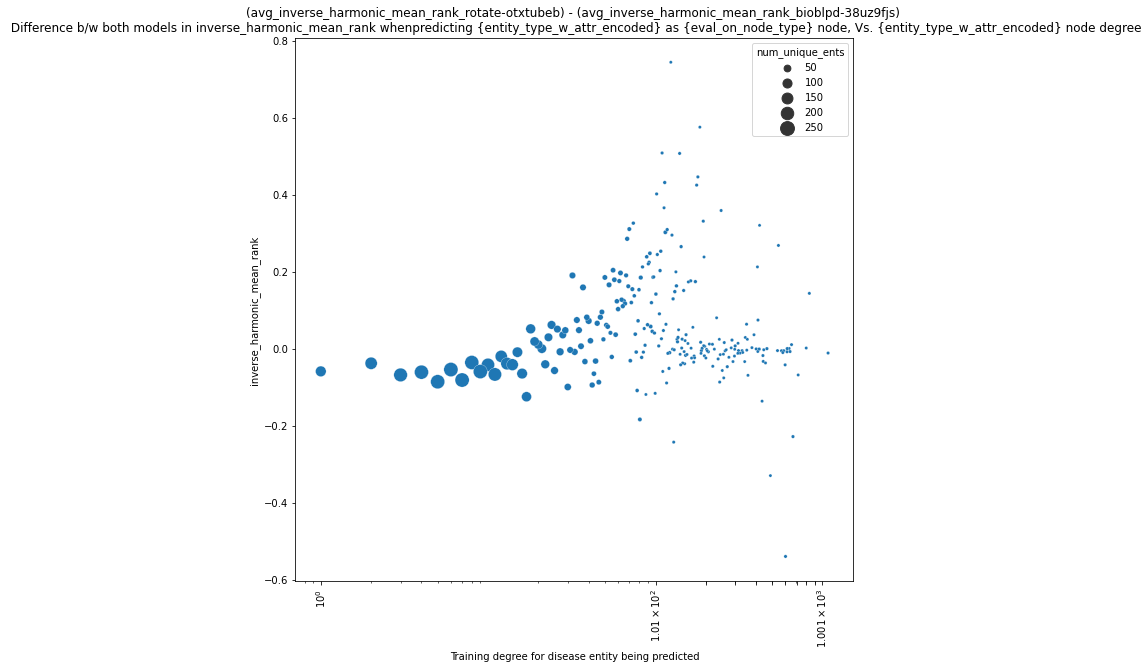

In [37]:
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D_old
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpd_old,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_by_node_degree_dicts_rotate_disease_src,
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT) 
merged_bioblpd_rotate_df[:3]

,degree,hits_at_1_rotate,hits_at_3_rotate,hits_at_5_rotate,hits_at_10_rotate,inverse_harmonic_mean_rank_rotate,count,arithmetic_mean_rank,adjusted_arithmetic_mean_rank,inverse_harmonic_mean_rank_bioblp,hits_at_1_bioblp,hits_at_3_bioblp,hits_at_5_bioblp,hits_at_10_bioblp,num_unique_ents,hits_at_1,hits_at_3,hits_at_5,hits_at_10,inverse_harmonic_mean_rank
0,148.0,0.103448,0.241379,0.310345,0.413793,0.204842,29,546.261902,0.010306,0.076215,0.047619,0.047619,0.071429,0.142857,4,0.055829,0.193760,0.238916,0.270936,0.128627
1,4.0,0.073016,0.082540,0.095238,0.098413,0.083203,315,601.184204,0.011342,0.089921,0.052632,0.098684,0.105263,0.164474,254,0.020384,-0.016145,-0.010025,-0.066061,-0.006718
2,2.0,0.039648,0.048458,0.052863,0.057269,0.046961,227,751.289856,0.014175,0.040792,0.007246,0.050725,0.072464,0.108696,189,0.032401,-0.002266,-0.019600,-0.051427,0.006169


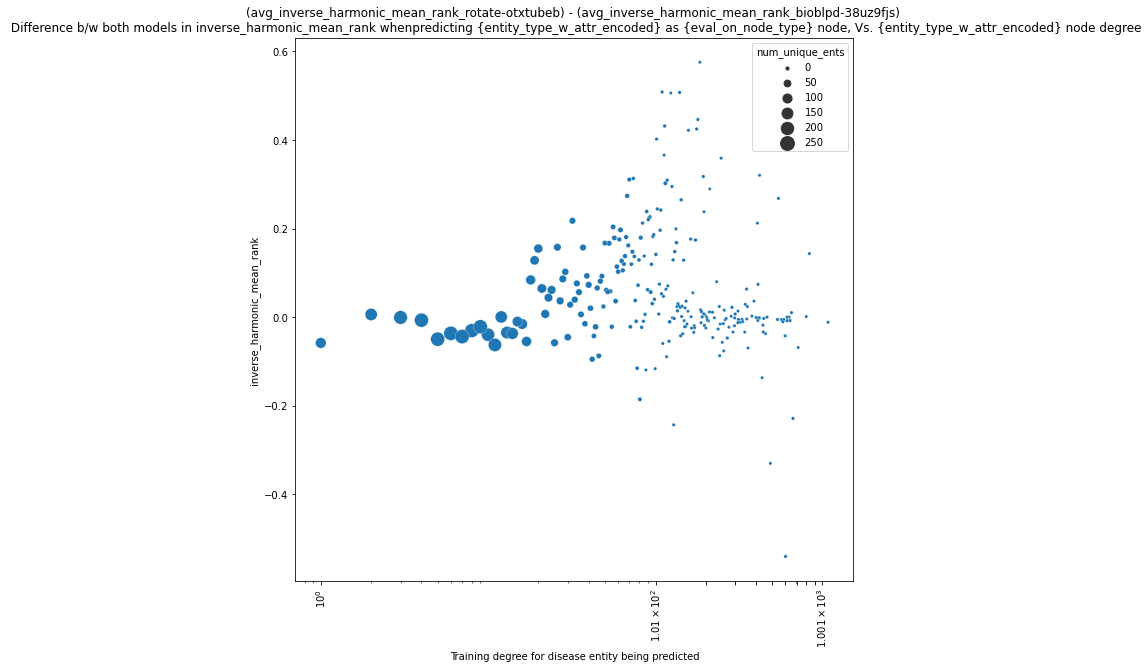

In [36]:
ENTITY_TYPE_W_ATTR_ENCODE = DISEASE
BIOBLP_MODEL_ID = BIOBLP_D_old
ROTATE_MODEL_ID = ROTATE
METRIC_TO_PLOT = INVERSE_HARMONIC_MEAN_RANK


test_triples_by_node_endpoint_to_predict = {
    node_endpoint: nde._create_test_df_subset_given_node_endpoint_type_to_predict(
        test_df=test_triples_ent_w_attr_df, 
        entity_type_to_predict = ENTITY_TYPE_W_ATTR_ENCODE,
        node_endpoint_to_predict=node_endpoint,
    ) for node_endpoint in [COL_SOURCE, COL_TARGET]
}

merged_bioblpd_rotate_df = merge_and_plot_node_degree_analysis_multimodel_lp_eval_diff(bioblp_model_id=BIOBLP_MODEL_ID,
                                                            bioblp_eval_results=results_by_node_degree_dicts_bioblpd_old,
                                                            rotate_model_id=ROTATE_MODEL_ID,
                                                            rotate_eval_results=results_dicts[ENTITY_TYPE_W_ATTR_ENCODE][ROTATE_MODEL_ID],
                                                            node_endpoint_type_for_entity_w_attribute=COL_SOURCE,
                                                            eval_on_node_endpoint=EVAL_NODE_HEAD,
                                                            test_triples=test_triples_by_node_endpoint_to_predict[COL_SOURCE],
                                                            entity_type_w_attr_encoded=ENTITY_TYPE_W_ATTR_ENCODE,
                                                            metric_name=METRIC_TO_PLOT) 
merged_bioblpd_rotate_df[:3]

In [208]:
### plot metrics

In [25]:
import matplotlib.pyplot as plt
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_single_model
from nb_utils.plot_utils import plot_metric_vs_degree_scatterplot_multi_models

img_outdir = Path('./data/imgs/')


note,not all the cells have been amended after changing the structure of the eval results dictionary to store 'head', 'tail', 'both', results,
so if you face an error whilst plotting, try accessing the dictionaries at the 'head', 'tail', or 'both' keys of the results_dictionaries directly. E.g. results_by_node_degree_dicts_rotate_drug['head'] insetead of 'tail'


In [26]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_prot[EVAL_NODE_HEAD],
                     BIOBLP_P: results_by_node_degree_dicts_bioblpp[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_10, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


NameError: name 'results_by_node_degree_dicts_rotate_prot' is not defined

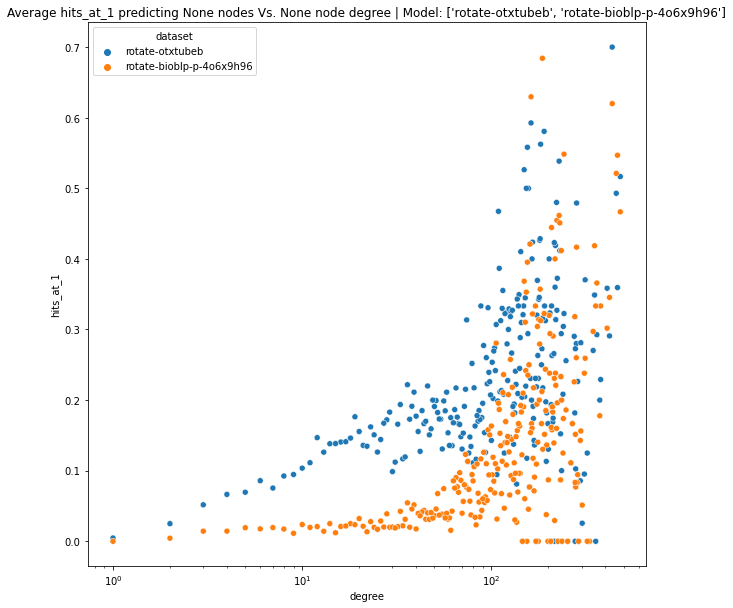

In [43]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_1, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


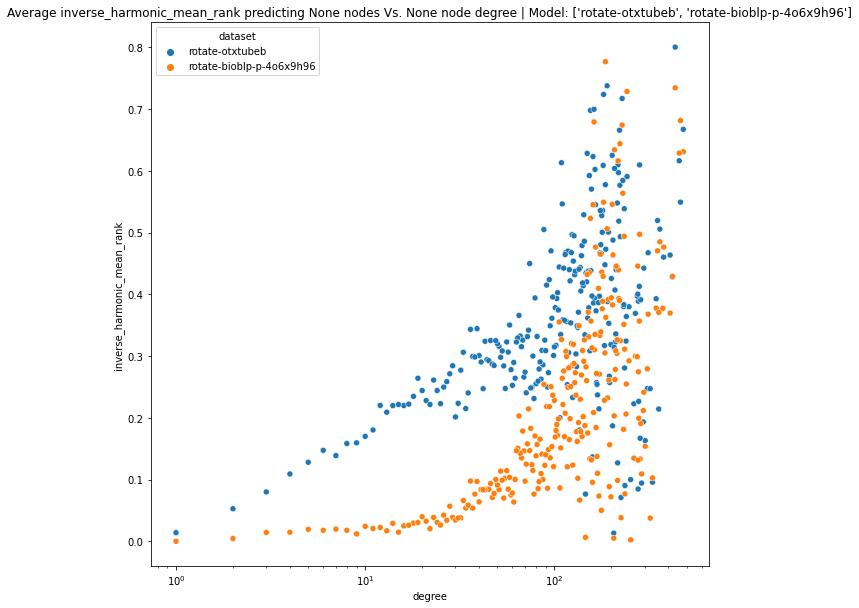

In [46]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpp"
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=INVERSE_HARMONIC_MEAN_RANK, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


In [45]:
#molecules

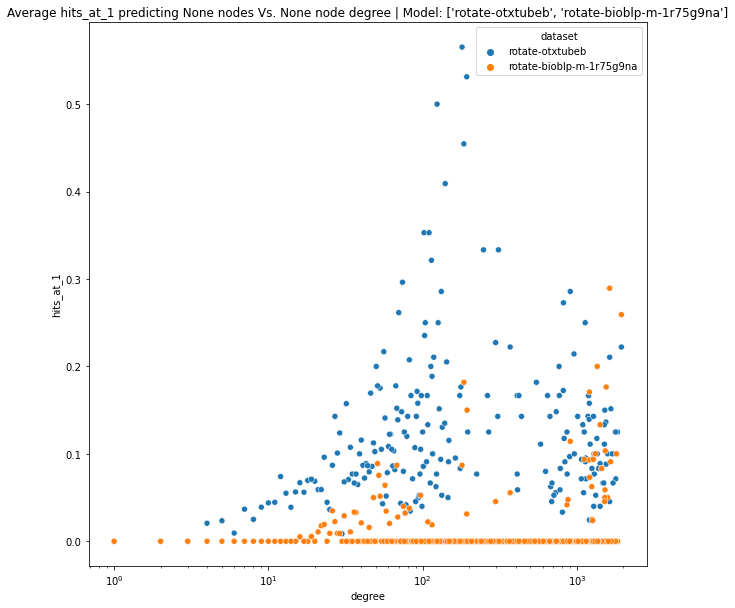

In [77]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug[EVAL_NODE_HEAD],
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_1, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


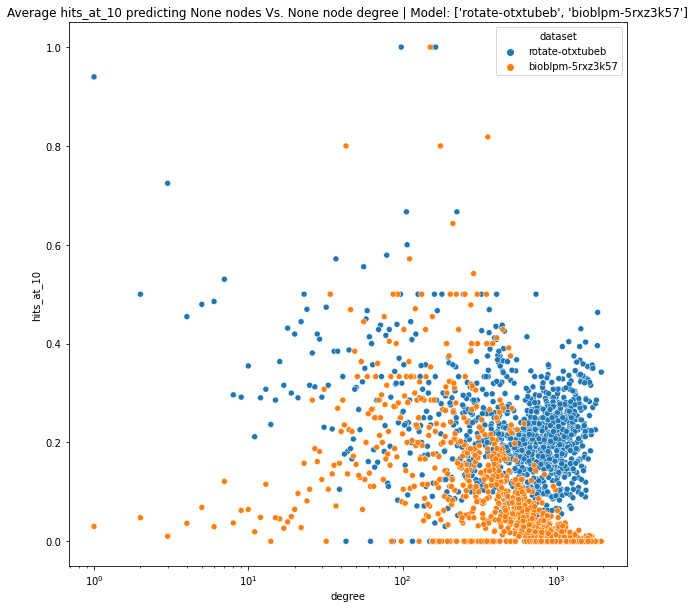

In [238]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug[EVAL_NODE_HEAD],
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=HITS_AT_10, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)


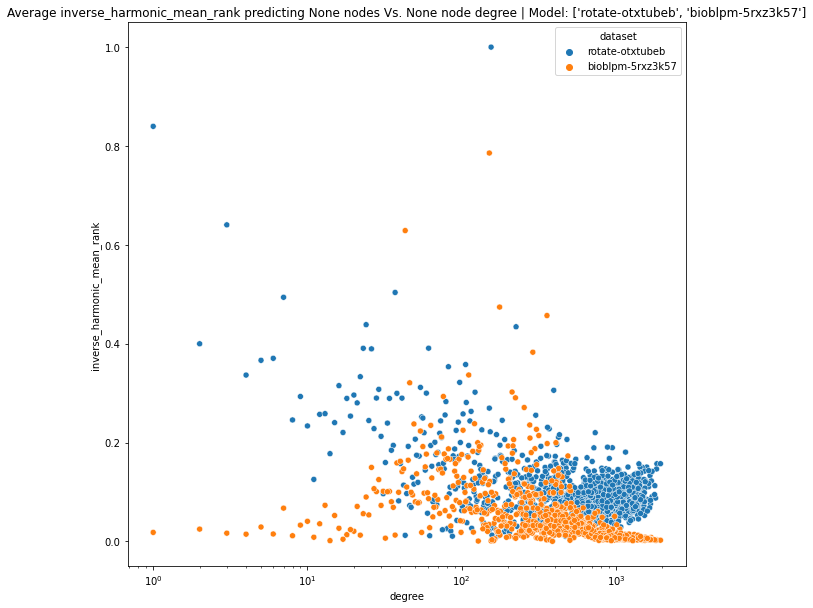

In [239]:
EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS = "./data/imgs/node-degree-analysis-rotate-and-bioblpm"
model_result_dicts = {ROTATE: results_by_node_degree_dicts_rotate_drug[EVAL_NODE_HEAD],
                     BIOBLP_M: results_by_node_degree_dicts_bioblpm[EVAL_NODE_HEAD]}#results_by_node_degree_dicts_bioblp}
x = plot_metric_vs_degree_scatterplot_multi_models(metric_name=INVERSE_HARMONIC_MEAN_RANK, results_by_node_degree_dicts_combined=model_result_dicts,
                                                  eval_out_dir=EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS)



#### previous stuff

In [98]:
wandb.login()

True

In [99]:
tags = {"model_name": BIOBLP_M),
        "study_name": 'node_degree_trends_both_models_combined',
        "test_set_type": TEST_RESTRICTED_ENT}
run = setup_wandb_result_tracker(**tags, 
                                 notes=f'combined lp results for {BIOBLP_M)} and {MODELS.get(ROTATE)}', 
                                 project_name='bioblp-jupyter-trial',
                                 wandb_entity='discoverylab')

Save custom plots to Weights and biases

In [117]:
!ls {EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}

20230324-173105-hits_at_1_node_degree_analysis-rotate-otxtubeb-20230324-173105.png
20230324-173137-hits_at_10_node_degree_analysis-rotate-otxtubeb-20230324-173137.png
20230324-173248-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-20230324-173248.png
20230324-173341-hits_at_1_node_degree_analysis-bioblpp-cttc3ucm-20230324-173341.png
20230324-173404-hits_at_10_node_degree_analysis-bioblpp-cttc3ucm-20230324-173404.png
20230324-173426-inverse_harmonic_mean_rank_node_degree_analysis-bioblpp-cttc3ucm-20230324-173426.png
20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png
20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png


In [120]:
#degree_analysis_hits_at_1_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174539-hits_at_1_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
#degree_analysis_hits_at_10_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174536-hits_at_10_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"
degree_analysis_mrr_rotate_and_bioblpp_path = f"{EVAL_OUT_DIR_NODE_DEGREE_ANALYSIS}/20230324-174518-inverse_harmonic_mean_rank_node_degree_analysis-rotate-otxtubeb-bioblpp-cttc3ucm.png"

wandb.log({"hits@1_combined_bioblpm_rotate": wandb.Image(degree_analysis_hits_at_1_rotate_and_bioblpm_path)})
wandb.log({"hits@10_combined_bioblpm_rotate": wandb.Image(degree_analysis_hits_at_10_rotate_and_bioblpm_path)})
wandb.log({"mrr_combined_bioblpm_rotate": wandb.Image(degree_analysis_mrr_rotate_and_bioblpm_path)})